# **GRADED CHALLENGE 7 - COMPUTER VISION USING ANN**

___

# INTRODUCTION

Name    : Dewa Dwi Al-matin  
Batch   : FTDS HCK-013

## Objective
In recent years, there has been an increasing emphasis on workplace safety and personal protective equipment (PPE) compliance across various industries. One crucial aspect of PPE compliance is the proper use of masks, particularly in environments where respiratory hazards are present. However, ensuring consistent adherence to mask-wearing protocols can be challenging, leading to potential safety risks and regulatory non-compliance. In response, this project aims to develop an Artificial Neural Network (ANN) based computer vision system for classifying images of individuals based on their mask-wearing behavior. The system will be trained to categorize images into three classes: wearing a mask correctly, not wearing a mask, and wearing a mask improperly. The objective is to provide a robust tool for monitoring mask compliance in industrial and occupational settings, ultimately enhancing workplace safety standards and regulatory compliance efforts.


___

# IMPORT LIBRARIES

In [32]:
# Data Manipulation
import os
import glob
import numpy as np
import pandas as pd
# import cv2

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.metrics import Recall

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


___

# DATA LOADING

In [2]:
# Listing images of each category

with_mask_files = glob.glob('data/with_mask/*')
without_mask_files = glob.glob('data/without_mask/*')

with_mask_files.sort()
without_mask_files.sort()

print('with_mask_files: ', with_mask_files[0])
print('')
print('with_mask_files: ', without_mask_files[0])

with_mask_files:  data/with_mask/with_mask_1.jpg

with_mask_files:  data/without_mask/without_mask_1.jpg


In [3]:
# Create a Pandas DataFrame that contains the path of all images

all_files = with_mask_files + without_mask_files
labels = ['with_mask' for i in range(len(with_mask_files))] + ['without_mask' for i in range(len(without_mask_files))]
img_df = pd.DataFrame({'images':all_files, 'label':labels})
img_df = img_df.sample(len(img_df)).reset_index(drop=True)
img_df

,images,label
0,data/without_mask/without_mask_1449.jpg,without_mask
1,data/without_mask/without_mask_1902.jpg,without_mask
2,data/with_mask/with_mask_1643.jpg,with_mask
3,data/with_mask/with_mask_832.jpg,with_mask
4,data/without_mask/without_mask_1019.jpg,without_mask
...,...,...
7548,data/without_mask/without_mask_2058.jpg,without_mask
7549,data/with_mask/with_mask_2269.jpg,with_mask
7550,data/with_mask/with_mask_2480.jpg,with_mask
7551,data/with_mask/with_mask_3662.jpg,with_mask


___

# EXPLORATORY DATA ANALYSIS

Data set consists of 7553 RGB images in 2 folders as with_mask and without_mask. Images are named as label with_mask and without_mask. Images of faces with mask are 3725 and images of faces without mask are 3828. Below are the example images frome each class.

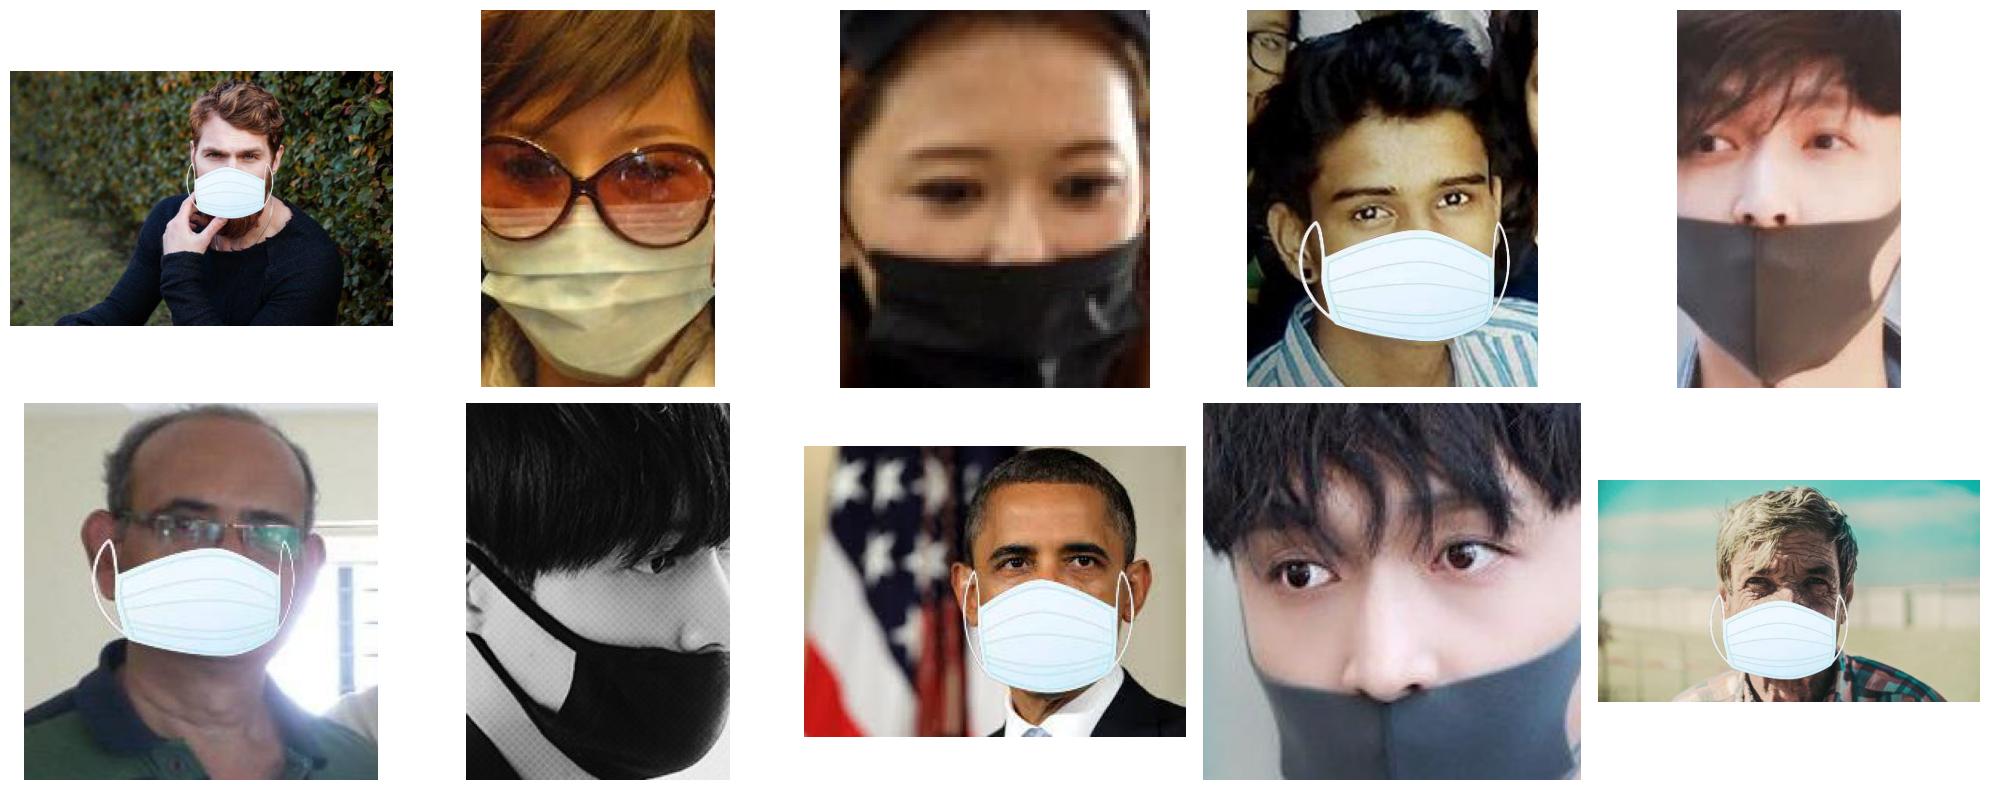

In [4]:
# Show with_mask images
num_images_to_show = 10

plt.figure(figsize=(20, 8))

for i in range(num_images_to_show):
    with_mask = plt.imread(with_mask_files[i])

    plt.subplot(2, 5, i + 1)
    plt.imshow(with_mask)
    plt.axis('off')

plt.tight_layout()
plt.show()

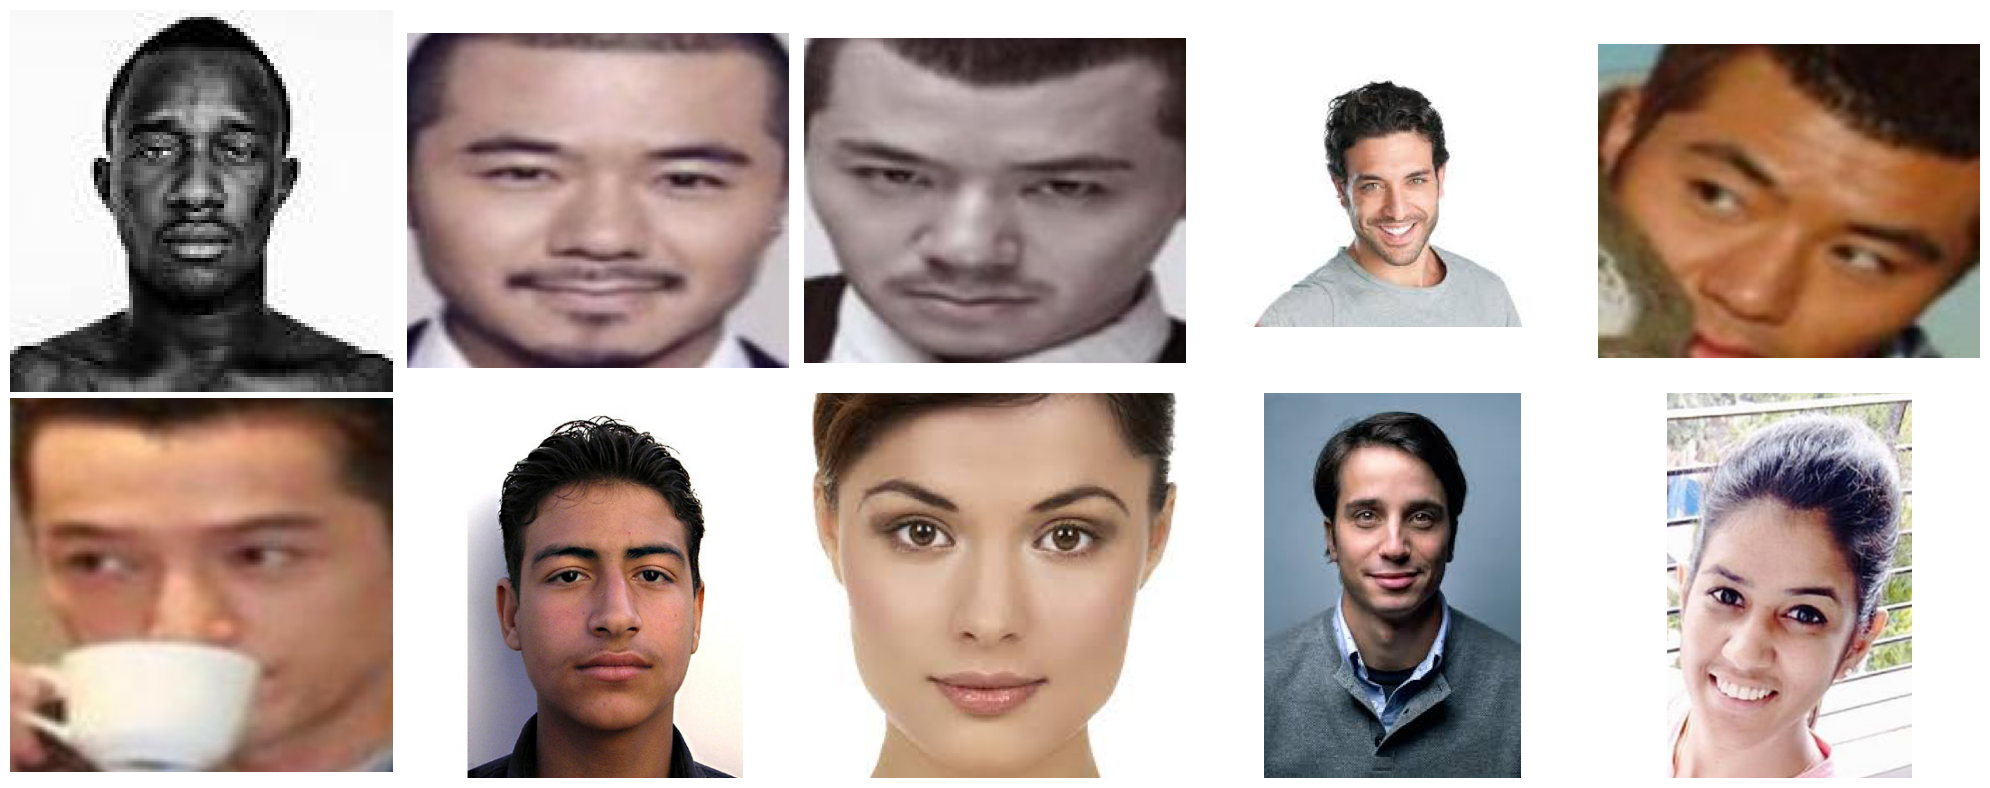

In [5]:
# Show without_mask images
num_images_to_show = 10

plt.figure(figsize=(20, 8))

for i in range(num_images_to_show):
    without_mask = plt.imread(without_mask_files[i])

    plt.subplot(2, 5, i + 1)
    plt.imshow(without_mask)
    plt.axis('off')

plt.tight_layout()
plt.show()

___

# FEATURE ENGINEERING

The code below prepares the data for training and testing an image classification model by splitting it into training/validation and test sets and setting up data generators for basic image preprocessing.

## Dataset Split

In [6]:
# Splitting data into train and test/validation (80% train_val, 20% test)
train_val_df, test_df = train_test_split(img_df, test_size=0.2, random_state=42)

# Check the lengths of each set
print("Train set length:", len(train_val_df))
print("Test set length:", len(test_df))

Train set length: 6042
Test set length: 1511


In [62]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

In [63]:
train = train_gen.flow_from_dataframe(dataframe=train_val_df,
                                        x_col="images",
                                        y_col="label",
                                        color_mode="rgb",
                                        class_mode="binary",
                                        target_size=(128,128),
                                        subset="training")

Found 4834 validated image filenames belonging to 2 classes.


In [64]:
val = train_gen.flow_from_dataframe(dataframe=train_val_df,
                                        x_col="images",
                                        y_col="label",
                                        color_mode="rgb",
                                        class_mode="binary",
                                        target_size=(128,128),
                                        subset="validation")

Found 1208 validated image filenames belonging to 2 classes.


In [65]:
test = test_gen.flow_from_dataframe(dataframe=test_df,
                                        x_col="images",
                                        y_col="label",
                                        color_mode="rgb",
                                        class_mode="binary",
                                        target_size=(128,128),
                                        shuffle=False)

Found 1511 validated image filenames belonging to 2 classes.


___

# ANN TRAINING - BASE MODEL

## Model Definition

In [34]:
# Clear session

seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [35]:
# Create Sequential API model

base_model = Sequential()
base_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
base_model.add(MaxPooling2D(2, 2))
base_model.add(Conv2D(64, (3,3), activation='relu'))
base_model.add(MaxPooling2D(2, 2))
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))

# Compile
base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['Recall'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

This model is a sequential convolutional neural network (CNN) designed for binary image classification tasks. Below is a breakdown of each layer in the model:

- **Input Layer (Conv2D):** This layer convolves the input image with 32 filters of size 3x3, resulting in feature maps of size 126x126. The number of parameters in this layer is determined by the size of the filter (3x3) multiplied by the number of input channels (3 for RGB images) multiplied by the number of output channels (32).

- **MaxPooling2D Layer:** This layer performs max pooling on the feature maps generated by the previous convolutional layer, reducing their spatial dimensions by half (from 126x126 to 63x63) while retaining the most important information.

- **Convolutional Layer (Conv2D):**
Similar to the first convolutional layer, this layer convolves the input with 64 filters of size 3x3, resulting in feature maps of size 61x61.

- **MaxPooling2D Layer:** Another max pooling layer that further reduces the spatial dimensions of the feature maps by half (from 61x61 to 30x30).

- **Flatten Layer:** This layer flattens the 3D feature maps into a 1D vector, preparing them for input to the fully connected layers.

- **Dense Layer (Fully Connected):** A fully connected layer with 128 neurons. Each neuron is connected to every neuron in the previous layer. This layer contains the majority of the model's parameters.

- **Output Layer (Dense):** The output layer with a single neuron, used for binary classification. The output represents the probability of belonging to the positive class (e.g., with mask).

The model has a total of 7,392,449 parameters, all of which are trainable. It uses Rectified Linear Unit (ReLU) activation functions for the convolutional and dense layers. The final layer uses a sigmoid activation function for binary classification tasks.

We use recall as a metric because it focuses on minimizing false negatives, which is crucial for identifying individuals not wearing masks accurately. This prioritization helps ensure public health and safety by minimizing the risk of missing instances where individuals are not adhering to mask-wearing guidelines.

## Model Training

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_recall", patience=4 ,mode="max", verbose=1, restore_best_weights=True)

In [37]:
history = base_model.fit(train, epochs=20, validation_data=(val), callbacks=callback)

Epoch 1/20
152/152 [==============================] - 48s 312ms/step - loss: 0.4012 - recall: 0.8363 - val_loss: 0.2974 - val_recall: 0.9608
Epoch 2/20
152/152 [==============================] - 49s 321ms/step - loss: 0.2382 - recall: 0.9190 - val_loss: 0.2373 - val_recall: 0.9527
Epoch 3/20
152/152 [==============================] - 49s 320ms/step - loss: 0.1701 - recall: 0.9430 - val_loss: 0.2219 - val_recall: 0.9674
Epoch 4/20
152/152 [==============================] - 48s 315ms/step - loss: 0.1270 - recall: 0.9568 - val_loss: 0.2347 - val_recall: 0.9608
Epoch 5/20
152/152 [==============================] - 48s 313ms/step - loss: 0.0874 - recall: 0.9707 - val_loss: 0.2377 - val_recall: 0.9250
Epoch 6/20
152/152 [==============================] - 48s 315ms/step - loss: 0.0513 - recall: 0.9870 - val_loss: 0.2849 - val_recall: 0.8972
Epoch 7/20
152/152 [==============================] - 48s 317ms/step - loss: 0.0275 - recall: 0.9943 - val_loss: 0.3252 - val_recall: 0.9364
Epoch 7: earl

In this training process, early stopping is applied to prevent overfitting by monitoring the model's performance on a validation set. It stops the training when the validation recall does not improve for 4 epochs. Here, early stopping occurred at epoch 7, restoring the model's weights from the best-performing epoch (epoch 3).

## Model Evaluation

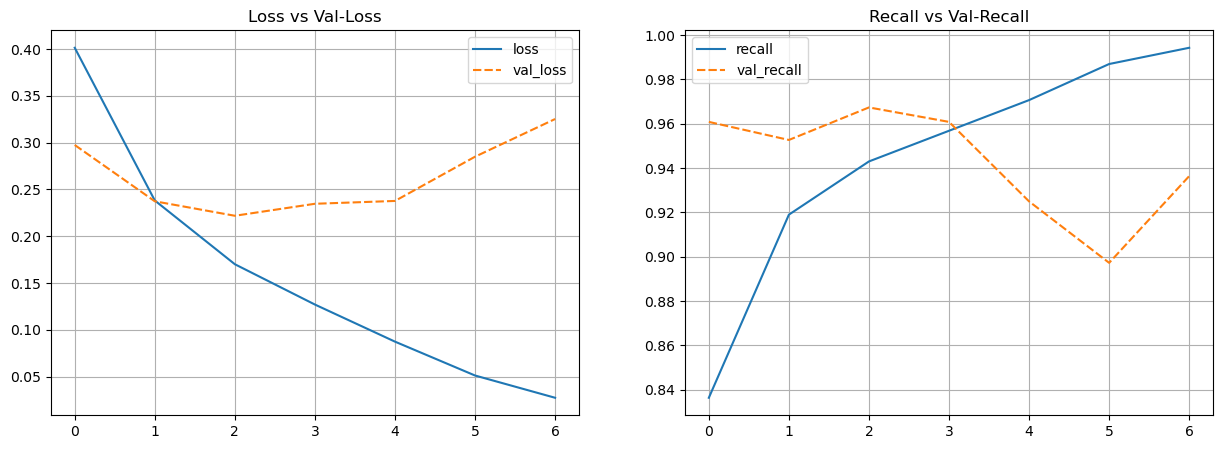

In [38]:
fit_history = pd.DataFrame(history.history)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=fit_history[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=fit_history[['recall', 'val_recall']])
plt.grid()
plt.title('Recall vs Val-Recall')
plt.show()

Focusing on the recall chart, we can see that the model starts to overfit from the third epoch. that is why we use early stopping callback, to save the best epoch (which is 3 in this case)

In [39]:
result = base_model.evaluate(test)
result

48/48 [==============================] - 7s 136ms/step - loss: 0.2371 - recall: 0.9736


[0.23714010417461395, 0.9736495614051819]

In [30]:
def turn_binary(array):
    i=0
    for item in array:
        if item > 0.5:
            array[i] = 1
        else:
            array[i] = 0
        i+=1

    return array

48/48 [==============================] - 7s 138ms/step


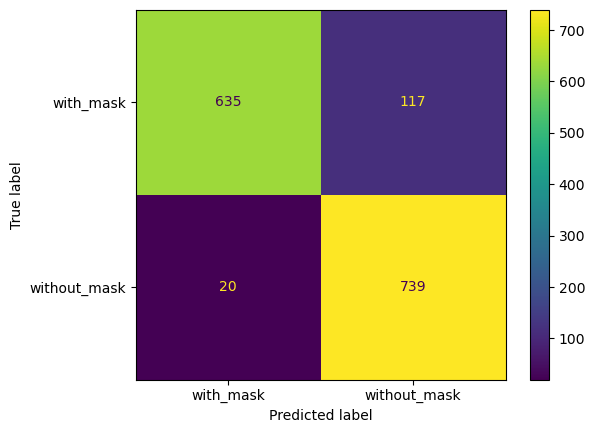

              precision    recall  f1-score   support

   with_mask       0.97      0.84      0.90       752
without_mask       0.86      0.97      0.92       759

    accuracy                           0.91      1511
   macro avg       0.92      0.91      0.91      1511
weighted avg       0.92      0.91      0.91      1511



In [40]:
# Check the performance of test-set

## Get the probability
y_pred_prob = base_model.predict(test)

## Get class with maximum probability
y_pred_class = turn_binary(y_pred_prob)

## Display Classification Report
cm = confusion_matrix(test.classes, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(list(train.class_indices.keys())))
disp.plot()
plt.show()
print(classification_report(test.classes, y_pred_class, target_names=np.array(list(train.class_indices.keys()))))

From the result above, we can observe that:

- **"with_mask" Class:** The recall for the "with_mask" class is 0.84, indicating that 84% of actual instances where individuals are wearing masks were correctly identified by the model. While this suggests that the model is effective at detecting individuals wearing masks, there is still room for improvement, as some instances of individuals wearing masks were missed by the model.

- **"without_mask" Class:** In contrast, the recall for the "without_mask" class is 0.97, indicating that 97% of actual instances where individuals are not wearing masks were correctly identified by the model. This high recall value suggests that the model is particularly effective at detecting instances where individuals are not adhering to mask-wearing guidelines, which is crucial for public health and safety.

Overall, while the model demonstrates strong performance in identifying individuals not wearing masks (as indicated by the high recall for the "without_mask" class), there is some room for improvement in detecting instances of individuals wearing masks (as indicated by the lower recall for the "with_mask" class). Further optimization could enhance the model's ability to accurately identify individuals wearing masks, while keeping the high number for our main objective.

# ANN IMPROVEMENT - AUGMENTATION + DROPOUT +  EXTRA LAYER

## Augmentation

In [58]:
train_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1], 
    channel_shift_range=10,       
    fill_mode='nearest'
)

test_augmentation = ImageDataGenerator(rescale=1./255)

# Flow from dataframe with augmentation
train_aug = train_augmentation.flow_from_dataframe(
    dataframe=train_val_df,
    x_col="images",
    y_col="label",
    color_mode="rgb",
    class_mode="binary",
    target_size=(128, 128),
    subset="training"
)

val_aug = train_augmentation.flow_from_dataframe(
    dataframe=train_val_df,
    x_col="images",
    y_col="label",
    color_mode="rgb",
    class_mode="binary",
    target_size=(128, 128),
    subset="validation"
)

test_aug = test_augmentation.flow_from_dataframe(
    dataframe=test_df,
    x_col="images",
    y_col="label",
    color_mode="rgb",
    class_mode="binary",
    target_size=(128, 128),
    shuffle=False
)

Found 5438 validated image filenames belonging to 2 classes.
Found 604 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.



This augmentation configuration enhances the previous model by introducing a variety of transformations to the training images, thereby increasing the model's robustness and ability to generalize to new, unseen data.

- **rotation_range:** Randomly rotates images within the range of -10 to +10 degrees, providing variations in orientation.

- **width_shift_range and height_shift_range:** Randomly shifts the width and height of images by up to 10% of the total width and height, respectively, introducing translations.

- **shear_range:** Applies shear transformations with a maximum shear angle of 0.1, causing stretching or skewing of images.

- **zoom_range:** Randomly zooms into or out of images by up to 10%, adding scale variations.

- **horizontal_flip:** Randomly flips images horizontally, augmenting the dataset with mirror images.

- **brightness_range:** Adjusts the brightness of images within the range [0.9, 1.1], creating variations in lighting conditions.

- **channel_shift_range:** Randomly shifts the intensity values of image channels by up to 10 units, further diversifying pixel values.

Overall, this augmentation strategy introduces a wide range of transformations to the training images, simulating various real-world scenarios and enhancing the model's ability to learn meaningful patterns from diverse data distributions.

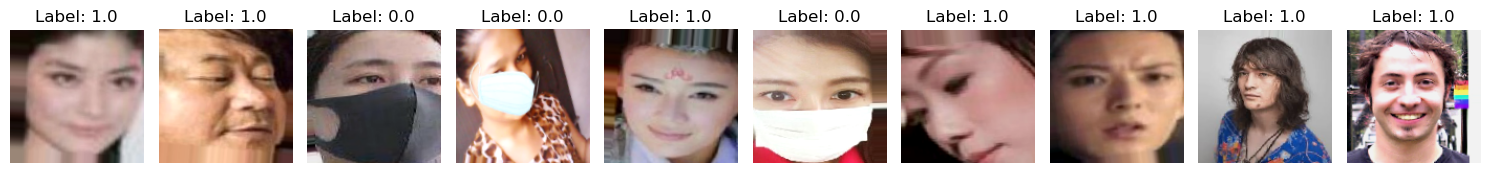

In [67]:
# Display a few augmented images
num_images_to_display = 10
fig, ax = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    image, label = train_aug.next()  # Get the next batch
    ax[i].imshow(image[0])  # Display the augmented image
    ax[i].axis('off')  # Turn off axis labels
    ax[i].set_title(f'Label: {label[0]}')  # Display the label

plt.tight_layout()
plt.show()

## Model Definition

In [72]:
# Clear session

seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [73]:
# Create Sequential API model

tuned_model = Sequential()
tuned_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128,3)))
tuned_model.add(MaxPooling2D(2, 2))
tuned_model.add(Conv2D(64, (3,3), activation='relu'))
tuned_model.add(MaxPooling2D(2, 2))
tuned_model.add(Conv2D(128, (3,3),activation='relu'))
tuned_model.add(MaxPooling2D(2, 2))
tuned_model.add(Flatten())
tuned_model.add(Dropout(0.5))
tuned_model.add(Dense(256, activation='relu'))
tuned_model.add(Dense(1, activation='sigmoid'))

# Compile
tuned_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['Recall'])
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In this updated model, there are two notable improvements compared to the previous model:

- **Additional Convolutional Layer:** This model introduces an additional convolutional layer (conv2d_2) with 128 filters. Adding more convolutional layers allows the model to learn more complex features from the input images, potentially capturing finer details and patterns that may be crucial for accurate classification. By increasing the depth of the model, it becomes more capable of extracting hierarchical representations of the input data, which can lead to improved performance.

- **Dropout Layer:** A dropout layer (dropout) is added after the flatten layer. Dropout is a regularization technique commonly used in neural networks to prevent overfitting. During training, dropout randomly sets a fraction of the input units to zero, effectively "dropping out" some neurons. This helps to reduce the interdependence between neurons and prevents the model from relying too heavily on any particular feature, thus improving generalization. By including a dropout layer, this model is less likely to overfit to the training data and is expected to generalize better to unseen data.

## Model Training

In [74]:
# Train the Model

history = tuned_model.fit(train_aug, epochs=20, validation_data=(val_aug), callbacks=callback)

Epoch 1/20
170/170 [==============================] - 77s 448ms/step - loss: 0.4731 - recall: 0.7663 - val_loss: 0.3112 - val_recall: 0.8641
Epoch 2/20
170/170 [==============================] - 77s 450ms/step - loss: 0.3196 - recall: 0.8736 - val_loss: 0.3244 - val_recall: 0.7864
Epoch 3/20
170/170 [==============================] - 77s 454ms/step - loss: 0.2684 - recall: 0.8790 - val_loss: 0.2346 - val_recall: 0.8770
Epoch 4/20
170/170 [==============================] - 76s 447ms/step - loss: 0.2394 - recall: 0.8957 - val_loss: 0.2204 - val_recall: 0.9029
Epoch 5/20
170/170 [==============================] - 75s 440ms/step - loss: 0.2241 - recall: 0.9058 - val_loss: 0.1904 - val_recall: 0.9094
Epoch 6/20
170/170 [==============================] - 75s 438ms/step - loss: 0.1920 - recall: 0.9225 - val_loss: 0.2133 - val_recall: 0.9450
Epoch 7/20
170/170 [==============================] - 74s 436ms/step - loss: 0.1965 - recall: 0.9185 - val_loss: 0.1773 - val_recall: 0.9061
Epoch 8/20
17

In this training process, we got to the 20th epoch but the callback still saved the best epoch which is the 16th.

## Model Evaluation

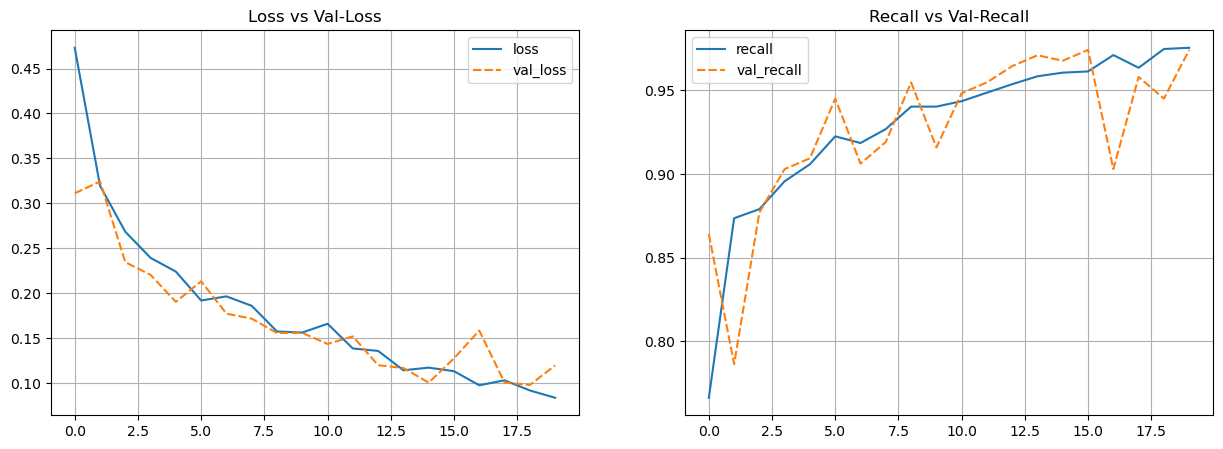

In [75]:
fit_history = pd.DataFrame(history.history)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=fit_history[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=fit_history[['recall', 'val_recall']])
plt.grid()
plt.title('Recall vs Val-Recall')
plt.show()

We can clearly see the improvement from the base model, we took care of the overfitting issue, raise the recall, and overall boost performance.

In [76]:
result = tuned_model.evaluate(test)
result

48/48 [==============================] - 7s 153ms/step - loss: 0.1031 - recall: 0.9842


[0.10311606526374817, 0.9841897487640381]

48/48 [==============================] - 7s 147ms/step


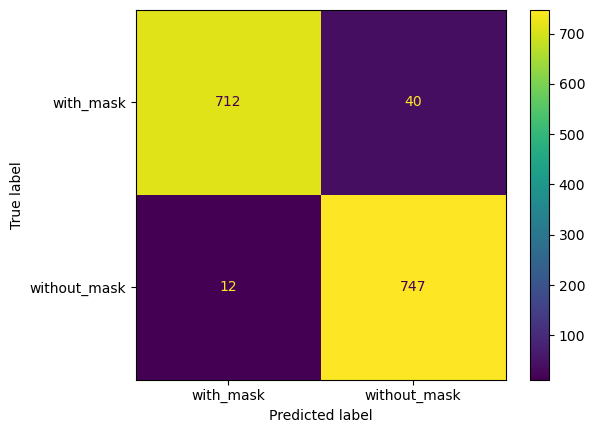

              precision    recall  f1-score   support

   with_mask       0.98      0.95      0.96       752
without_mask       0.95      0.98      0.97       759

    accuracy                           0.97      1511
   macro avg       0.97      0.97      0.97      1511
weighted avg       0.97      0.97      0.97      1511



In [77]:
# Check the performance of test-set

## Get the probability
y_pred_prob = tuned_model.predict(test)

## Get class with maximum probability
y_pred_class = turn_binary(y_pred_prob)

## Display Classification Report
cm = confusion_matrix(test.classes, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(list(train.class_indices.keys())))
disp.plot()
plt.show()
print(classification_report(test.classes, y_pred_class, target_names=np.array(list(train.class_indices.keys()))))

We can clearly see a huge improvement from the base model such as:

-  **Recall Improvement:** The recall for both classes significantly improved in the updated model. For the "with_mask" class, the recall increased from 0.84 in the previous model to 0.95 in the updated model. This indicates that the updated model is more effective at correctly identifying individuals wearing masks, capturing 95% of actual instances. Similarly, for the "without_mask" class, the recall increased from 0.97 to 0.98, showing improved performance in identifying individuals not wearing masks, with 98% of actual instances correctly classified.

- **Enhanced Ability to Identify Positive Instances:** With higher recall values for both classes, the updated model demonstrates an improved ability to correctly identify positive instances, whether individuals are wearing masks or not. This enhancement is crucial, especially in scenarios where accurately detecting instances without masks is essential for public health and safety measures. Overall, the increased recall values signify a notable improvement in the model's capability to capture relevant instances from both classes, contributing to better performance and effectiveness in real-world applications.

___

# MODEL SAVING

In [78]:
# saving model
tuned_model.save('my_model.keras')

___

# INFERENCE

please refer to the inference notebook and huggingface

___

# CONCLUSION

## Overall Result:

- The final image classification model achieved exceptional performance, with high precision, recall, and F1-scores for both classes.

- Significant improvements were observed in the model's ability to accurately differentiate between individuals wearing masks and those without masks.

- The model demonstrates practical utility for public health and safety applications, particularly in monitoring mask-wearing compliance and mitigating the spread of infectious diseases.

## Limitations:

- The dataset used for training and evaluation may not fully represent all possible real-world scenarios, potentially limiting the model's generalization ability.

- Computational resources and time constraints may have limited the exploration of more complex model architectures or extensive hyperparameter tuning.

## Future Improvements:

- Enhance the dataset diversity by incorporating images with a wider range of mask types, angles, and environmental conditions to improve the model's robustness.

- Explore transfer learning techniques with pre-trained models on larger datasets to leverage existing knowledge and further boost performance.